## Récupération des données de l'API

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import requests
from statsmodels.tsa.arima_model import ARIMA


parametres = {
    'start_date':'2019-01-01',
    'end_date':'2019-09-07',
    'columns':['spend','revenue','profit','margin','nb_impressions','ecpm']}

r = requests.post('https://data-analyst-test.madboxgames.io/api/public/profit/get',params=parametres)


## Transformation des données en dataframe

In [2]:
data = r.text
j = json.loads(data)
y = j['data']
df = pd.DataFrame(j['data']['data'])
df.set_index('date', inplace=True)

df.head()

,ecpm,margin,nb_impressions,profit,revenue,spend
date,,,,,,
2019-01-01,49.59,0.34,59751.76,993.28,2963.14,1969.86
2019-01-02,49.98,0.32,62299.62,1002.36,3113.48,2111.12
2019-01-03,48.27,0.34,65199.64,1074.17,3146.88,2072.72
2019-01-04,49.73,0.33,63996.98,1061.52,3182.79,2121.26
2019-01-05,48.49,0.32,64038.54,992.10,3105.02,2112.92


In [3]:
df.describe()

,ecpm,margin,nb_impressions,profit,revenue,spend
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,50.058040,0.332000,79909.440360,1329.731320,3998.940000,2669.208600
std,1.276493,0.016743,8510.587954,161.063956,427.070377,287.826362
min,47.410000,0.300000,59751.760000,967.530000,2963.140000,1969.860000
25%,48.980000,0.320000,74008.952500,1214.000000,3664.420000,2462.900000
50%,49.985000,0.330000,79813.155000,1329.920000,3974.565000,2661.170000
75%,50.985000,0.340000,86349.677500,1439.602500,4306.485000,2888.230000
max,52.960000,0.370000,99058.080000,1791.140000,4990.630000,3317.850000


## Visualisation des différentes données

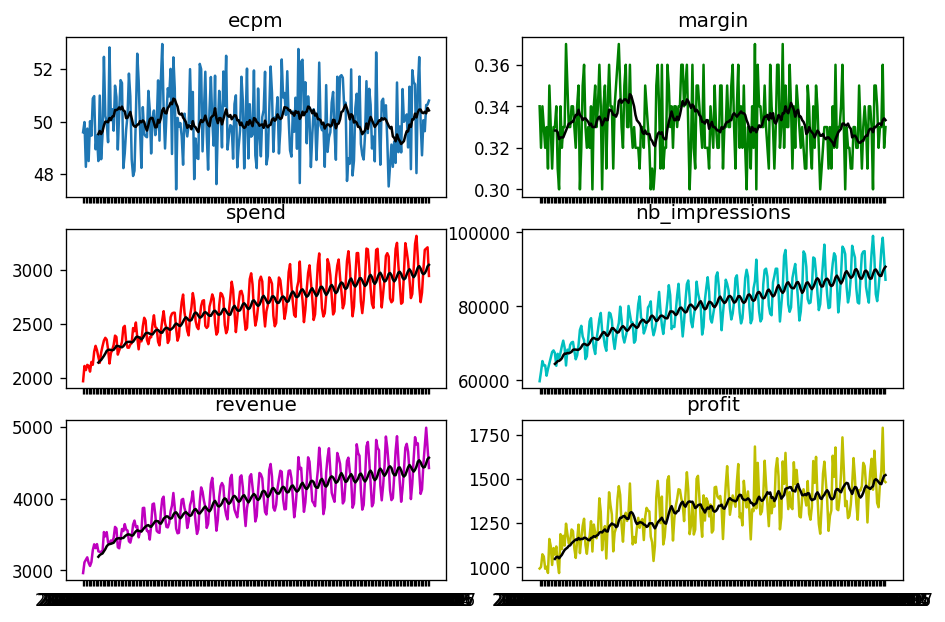

In [4]:
# Calcul des moyennes mobiles
rolling_mean = df.rolling(window = 12).mean()

# Graphiques des données

plt.rcParams.update({'figure.figsize':(9,6), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)

axes[0,0].plot(df.ecpm, label = 'ecpm')
axes[0,0].plot(rolling_mean.ecpm, 'black', label = 'rolling_mean')
axes[0,0].set_title('ecpm')
axes[0,1].plot(df.margin, 'g', label = 'margin')
axes[0,1].plot(rolling_mean.margin, 'black', label = 'rolling_mean')
axes[0,1].set_title('margin')
axes[1,0].plot(df.spend, 'r', label = 'spend')
axes[1,0].plot(rolling_mean.spend, 'black', label = 'rolling_mean')
axes[1,0].set_title('spend')
axes[1,1].plot(df.index, df.nb_impressions, 'c', label = 'nb_impressions')
axes[1,1].plot(rolling_mean.nb_impressions, 'black', label = 'rolling_mean')
axes[1,1].set_title('nb_impressions')
axes[2,0].plot(df.index, df.revenue, 'm', label = 'revenue')
axes[2,0].plot(rolling_mean.revenue, 'black', label = 'rolling_mean')
axes[2,0].set_title('revenue')
axes[2,1].plot(df.index, df.profit, 'y', label = 'profit')
axes[2,1].plot(rolling_mean.profit, 'black', label = 'rolling_mean')
axes[2,1].set_title('profit')

plt.show()

Ici, on remarque que les données suivent 2 tendances :
- ecrm et margin semblent être des valeurs semi-constantes
- le reste des champs ont l'air de courbes logarithmiques

## Algorithme de prédiction des profits : Arima

In [5]:
model = ARIMA(df.profit, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D.profit   No. Observations:                  249
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1505.801
Method:                       css-mle   S.D. of innovations            101.850
Date:                Fri, 14 Feb 2020   AIC                           3023.601
Time:                        00:51:53   BIC                           3044.706
Sample:                    01-02-2019   HQIC                          3032.096
                         - 09-07-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9958      0.823      2.425      0.015       0.383       3.609
ar.L1.D.profit     0.9485      0.078     12.197      0.000       0.796       1.101
ar.L2.D.profit    -0.5376      0.059

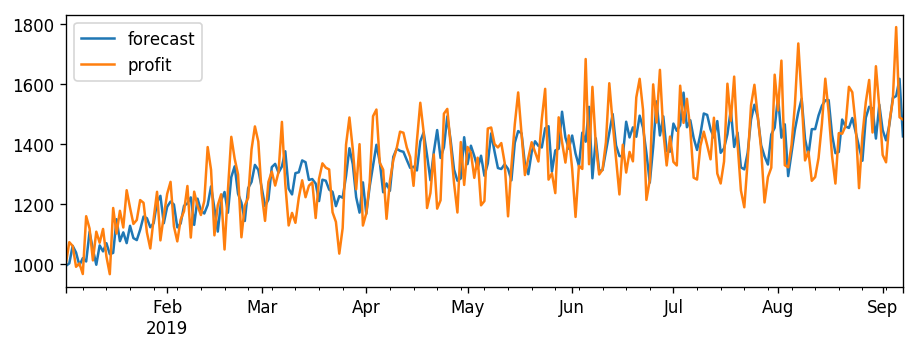

In [6]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

model_fit.plot_predict(dynamic=False)
plt.show()

Le modèle prédictif a ici l'air de matcher les données que l'on a.

On peut donc maintenant passer à l'entraînement du modèle pour prévoir la fin de l'année.

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


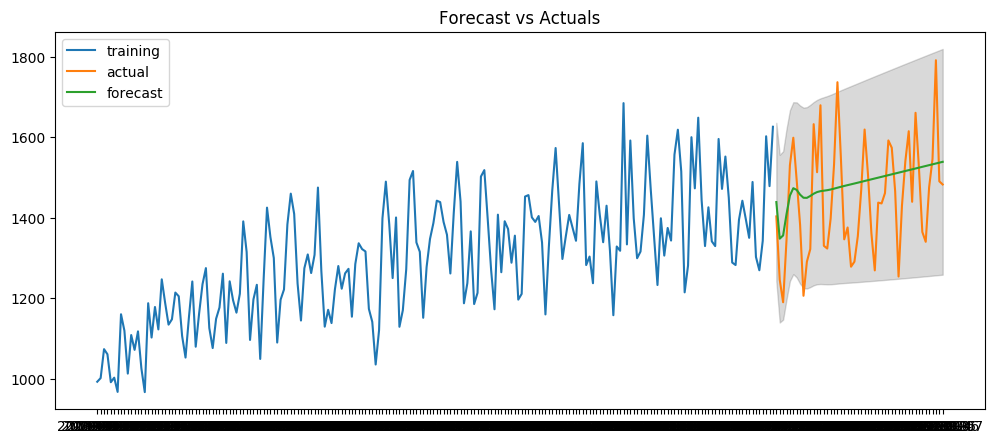

In [7]:
# On créer l'échantillon d'entraînement et de test (80/20)
train = df.profit[:200]
test = df.profit[200:]

# On crée le modèle ARIMA
model = ARIMA(train, order=(2, 1, 2))  
results = model.fit(disp=-1)  
fc, se, conf = results.forecast(50, alpha=0.05) 


fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)


plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend()

plt.show()

Notre courbe de prévision suit bien la tendance des vraies données, et l'intervalle de confiance à 95% englobe bien nos données.

On peut donc maintenant créer la courbe de prédiction pour la fin de l'année.

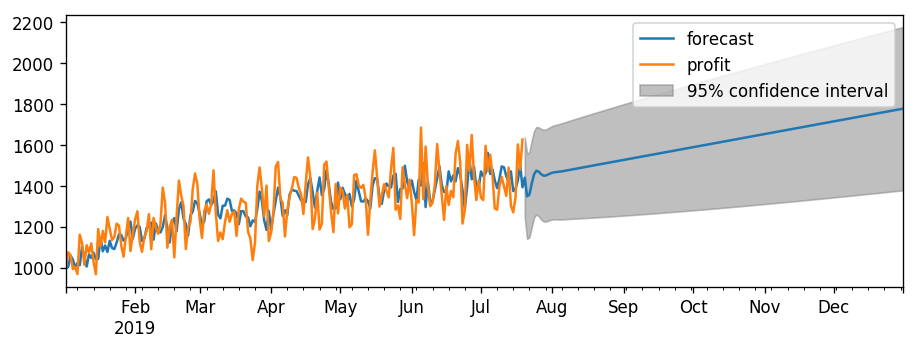

In [10]:
results.plot_predict(end='2019-12-31')